<a href="https://colab.research.google.com/github/SiddharthSoora/MovieRecommenderSystem_KNN/blob/main/Movie_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Exploratory Data Analysis

In [ ]:
ratings = pd.read_csv("/content/ratings.csv")
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
ratings = ratings.dropna()
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
movies = pd.read_csv("/content/movies.csv")
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [ ]:
n_ratings = len(ratings)
n_movies = len(ratings['movieId'].unique())
n_users = len(ratings['userId'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100004
Number of unique movieId's: 9066
Number of unique users: 671
Average ratings per user: 149.04
Average ratings per movie: 11.03


In [ ]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq

,userId,n_ratings
0,1,20
1,2,76
2,3,51
3,4,204
4,5,100
...,...,...
666,667,68
667,668,20
668,669,37
669,670,31


In [ ]:
# Find Lowest and Highest rated movies:
mean_rating = ratings.groupby('movieId')[['rating']].mean()
# Lowest rated movies
lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]


,movieId,title,genres
1062,1311,Santa with Muscles (1996),Comedy


In [ ]:
merger_ratings = pd.merge( movies, ratings, on = 'movieId', how = 'inner')
merger_ratings.head(1000)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1331380058
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.0,997938310
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,3.0,855190091
...,...,...,...,...,...,...
995,16,Casino (1995),Crime|Drama,452,4.0,976420133
996,16,Casino (1995),Crime|Drama,457,3.5,1471386880
997,16,Casino (1995),Crime|Drama,461,3.0,1090908858
998,16,Casino (1995),Crime|Drama,468,3.5,1296196073


In [ ]:
user_ratings = merger_ratings.groupby('userId').agg([np.size, np.mean])
user_ratings.head(100)

movieId               rating           timestamp              
          size          mean   size      mean      size          mean
userId                                                               
1           20   1675.600000     20  2.550000        20  1.260759e+09
2           76    354.828947     76  3.486842        76  8.353557e+08
3           51   8207.901961     51  3.568627        51  1.298890e+09
4          204   1721.514706    204  4.348039       204  9.498806e+08
5          100   6655.940000    100  3.910000       100  1.163374e+09
...        ...           ...    ...       ...       ...           ...
96          76   9022.828947     76  4.138158        76  1.223257e+09
97         128  12542.132812    128  3.015625       128  1.460343e+09
98          71  28186.098592     71  4.330986        71  1.459405e+09
99         188   1872.324468    188  3.430851       188  9.511098e+08
100         25    414.760000     25  3.400000        25  8.541940e+08

[100 rows x 6 columns]

In [ ]:
#grouping the rating based on user
ratings_grouped_by_users= merger_ratings.groupby('userId').agg([np.size,np.mean])
ratings_grouped_by_users

movieId              rating           timestamp              
          size         mean   size      mean      size          mean
userId                                                              
1           20  1675.600000     20  2.550000        20  1.260759e+09
2           76   354.828947     76  3.486842        76  8.353557e+08
3           51  8207.901961     51  3.568627        51  1.298890e+09
4          204  1721.514706    204  4.348039       204  9.498806e+08
5          100  6655.940000    100  3.910000       100  1.163374e+09
...        ...          ...    ...       ...       ...           ...
667         68   346.176471     68  3.647059        68  8.472716e+08
668         20  2027.900000     20  3.750000        20  9.936134e+08
669         37  2316.054054     37  3.351351        37  1.015829e+09
670         31  1267.677419     31  3.806452        31  9.390611e+08
671        115  2840.860870    115  3.917391       115  1.064845e+09

[671 rows x 6 columns]

In [ ]:
#grouping the rating based on movies
ratings_grouped_by_movies= merger_ratings.groupby('movieId').agg([np.size,np.mean])
ratings_grouped_by_movies

userId             rating           timestamp              
          size        mean   size      mean      size          mean
movieId                                                            
1          247  338.558704    247  3.872470       247  1.103116e+09
2          107  318.906542    107  3.401869       107  1.069321e+09
3           59  374.423729     59  3.161017        59  9.662429e+08
4           13  355.538462     13  2.384615        13  9.277797e+08
5           56  320.785714     56  3.267857        56  9.967201e+08
...        ...         ...    ...       ...       ...           ...
161944       1  287.000000      1  5.000000         1  1.470168e+09
162376       1   73.000000      1  4.500000         1  1.474256e+09
162542       1  611.000000      1  5.000000         1  1.471521e+09
162672       1  611.000000      1  3.000000         1  1.471524e+09
163949       1  547.000000      1  5.000000         1  1.476419e+09

[9066 rows x 6 columns]

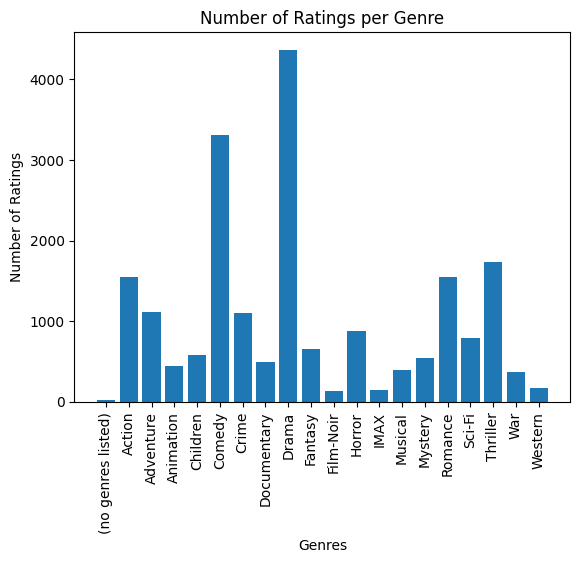

In [ ]:
# Split the genres column into multiple columns, each representing a single genre
genres_df = movies['genres'].str.get_dummies(sep='|')

# Combine the movie ID and title columns with the genres columns
genres_df = pd.concat([movies[['movieId', 'title']], genres_df], axis=1)

# Calculate the number of ratings received for each genre
genre_ratings = genres_df.drop(['movieId', 'title'], axis=1).sum()

# Create a bar chart using the number of ratings for each genre
plt.bar(genre_ratings.index, genre_ratings.values)
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings per Genre')
plt.show()


<ipython-input-14-ddc89c3af5c6>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ratings['rating'], kde=True)


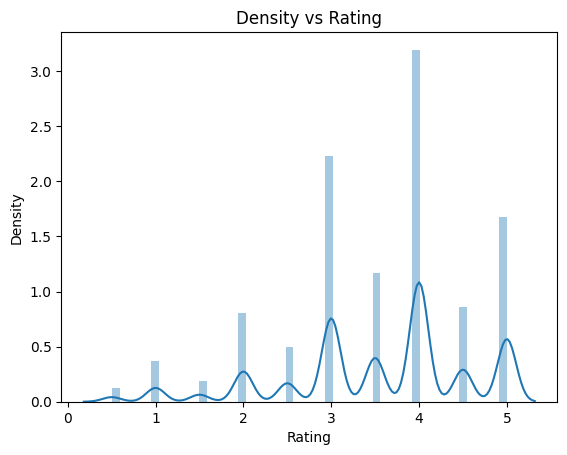

In [ ]:
# Create a distplot of density vs rating using seaborn
sns.distplot(ratings['rating'], kde=True)

# Set the x and y-axis labels and the chart title
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Density vs Rating')

# Display the chart
plt.show()


In [ ]:
# Highest rated movies
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]
# show number of people who rated movies rated movie highest
ratings[ratings['movieId']==highest_rated]


,userId,movieId,rating,timestamp
46719,344,53,5.0,850726154


<Axes: ylabel='movieId'>

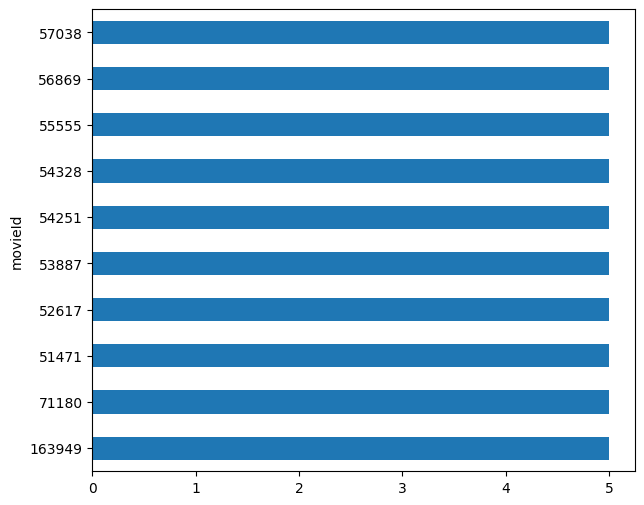

In [ ]:
#movies with high average rating
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='barh',figsize=(7,6))

In [ ]:
# show number of people who rated movies rated movie lowest
ratings[ratings['movieId']==lowest_rated]

,userId,movieId,rating,timestamp
87420,581,1311,0.5,1259726022


<Axes: ylabel='movieId'>

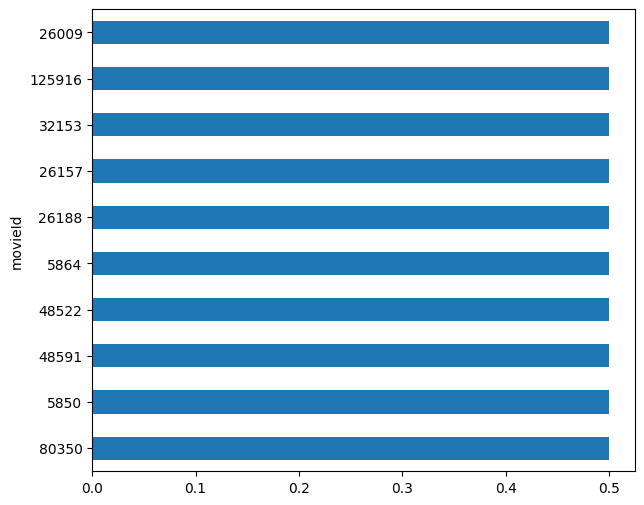

In [ ]:
#movies with lowest average rating
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=True).head(10).plot(kind='barh',figsize=(7,6))

In [ ]:
## the above movies has very low dataset. We will use bayesian average
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [ ]:
# Now, we create user-item matrix using scipy csr matrix
from scipy.sparse import csr_matrix

## Neighborhood based Collaborative Filtering

In [ ]:
def create_matrix(df):

    N = len(df['userId'].unique())
    M = len(df['movieId'].unique())

    # Map Ids to indices
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))

    # Map indices to IDs
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):

    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids


movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 16

similar_ids = find_similar_movies(movie_id, X, k=15)
movie_title = movie_titles[movie_id]

print(f"Since you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

Since you watched Casino (1995)
Jackie Brown (1997)
Goodfellas (1990)
Taxi Driver (1976)
Pulp Fiction (1994)
Rounders (1998)
Heat (1995)
Seven (a.k.a. Se7en) (1995)
Blair Witch Project, The (1999)
There's Something About Mary (1998)
Fargo (1996)
Clerks (1994)
Big Lebowski, The (1998)
American Beauty (1999)
Truman Show, The (1998)
Go (1999)


## Content Based Recommendation

In [ ]:
df_data = pd.read_csv("/content/movies_metadata.csv", encoding = 'utf-8')

<ipython-input-33-a84006cbb94d>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv("/content/movies_metadata.csv", encoding = 'utf-8')


In [ ]:
all_ratings = ratings['rating']
all_ratings

0         2.5
1         3.0
2         3.0
3         2.0
4         4.0
         ... 
99999     2.5
100000    4.0
100001    4.0
100002    2.5
100003    3.5
Name: rating, Length: 100004, dtype: float64

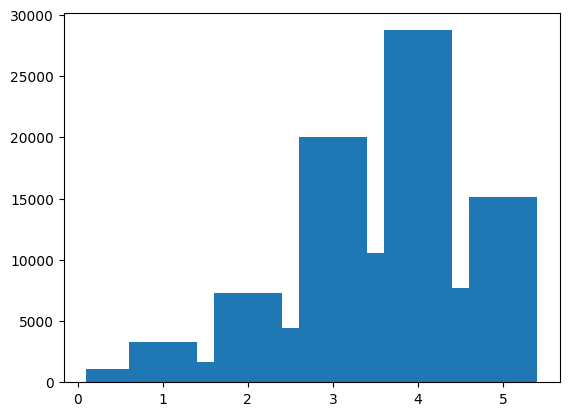

In [ ]:
rating_counts = {}
for rating in all_ratings:
    if rating in rating_counts:
        rating_counts[rating] += 1
    else:
        rating_counts[rating] = 1

plt.bar(rating_counts.keys(), rating_counts.values())
plt.show()

<ipython-input-36-d87cdee10ebd>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_data['vote_count'])


Text(0.5, 1.0, 'Histogram of vote counts')

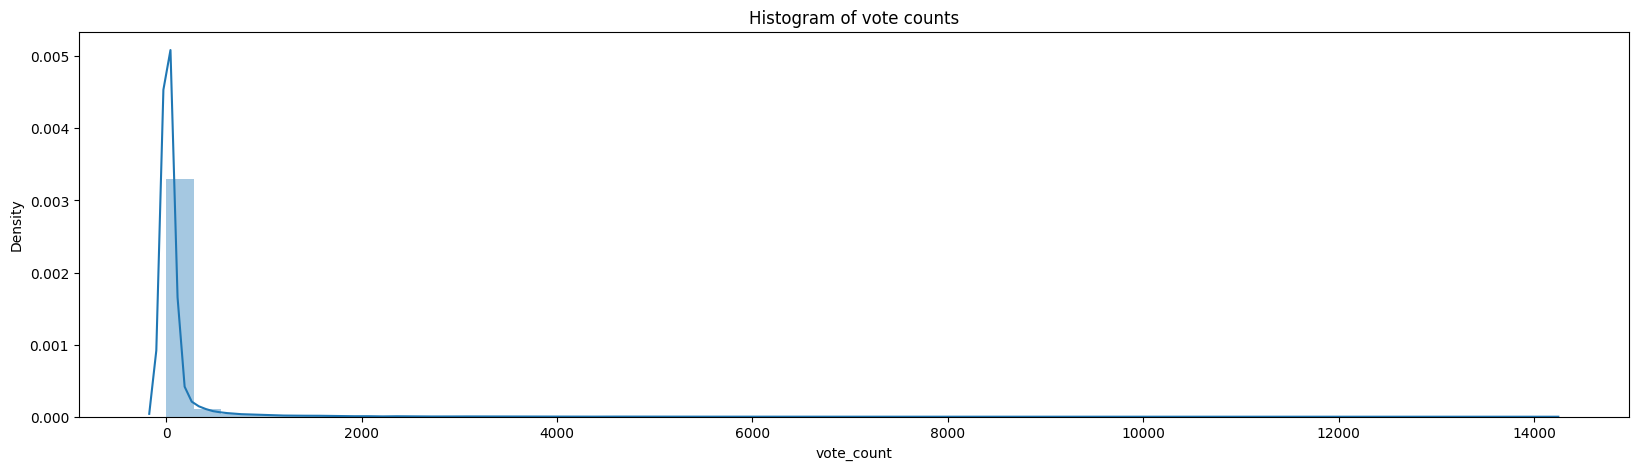

In [ ]:
df_data = df_data[df_data['vote_count'].notna()]
plt.figure(figsize=(20,5))
sns.distplot(df_data['vote_count'])
plt.title("Histogram of vote counts")

In [ ]:
min_votes = np.percentile(df_data['vote_count'].values, 85)

In [ ]:
df = df_data.copy(deep=True).loc[df_data['vote_count'] > min_votes]

In [ ]:
# removing rows with missing overview

df = df[df['overview'].notna()]

df.reset_index(inplace=True)


# processing of overviews

def process_text(text):

    # replace multiple spaces with one

    text = ' '.join(text.split())

    # lowercase

    text = text.lower()

    return text

df['overview'] = df.apply(lambda x: process_text(x.overview),axis=1)

<ipython-input-39-96cfb1fb5938>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overview'] = df.apply(lambda x: process_text(x.overview),axis=1)


In [ ]:
tf_idf = TfidfVectorizer(stop_words='english')

tf_idf_matrix = tf_idf.fit_transform(df['overview']);

In [ ]:
# calculating cosine similarity between movies

cosine_similarity_matrix = cosine_similarity(tf_idf_matrix, tf_idf_matrix)

In [ ]:
def index_from_title(df,title):

  return df[df['original_title']==title].index.values[0]


# function that returns the title of the movie from its index

def title_from_index(df,index):

  return df[df.index==index].original_title.values[0]


# generating recommendations for given title

def recommendations( original_title, df,cosine_similarity_matrix,number_of_recommendations):

  index = index_from_title(df,original_title)

  similarity_scores = list(enumerate(cosine_similarity_matrix[index]))

  similarity_scores_sorted = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

  recommendations_indices = [t[0] for t in similarity_scores_sorted[1:(number_of_recommendations+1)]]

  return df['original_title'].iloc[recommendations_indices]

In [ ]:
recommendations("Rambo: First Blood Part II", df, cosine_similarity_matrix, 20)

1037                                Rambo III
3564                                    Rambo
1036                              First Blood
3417                              Rescue Dawn
3646                                    Boy A
523                                    Nikita
5613                           Love and Honor
673                                     Spawn
689                                Wishmaster
1961                                 Impostor
4968                                  Phantom
5700                                 Blackhat
3001                                Pusher II
775                               Buffalo '66
4722    Pocahontas II: Journey to a New World
6757                              Shot Caller
3480                                      色‧戒
6569          Marvel One-Shot: The Consultant
2198                                  Firefox
194                             Carlito's Way
Name: original_title, dtype: object